In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/usbids1/USB-IDS-1-TRAIN.parquet
/kaggle/input/usbids1/USB-IDS-1-TEST.parquet
/kaggle/input/usbids1/USB-IDS-1-VALIDATION.parquet


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


In [13]:
import numpy as np
np.random.seed(42)


In [2]:
# Load the training data
df_train = pd.read_parquet('/kaggle/input/usbids1/USB-IDS-1-TRAIN.parquet')

# Print unique labels in the dataset
print(df_train['Label'].unique())


['TCPFlood-Evasive', 'Hulk-NoDefense', 'Benign', 'Hulk-Security2', 'Hulk-Reqtimeout', ..., 'Slowhttptest-NoDefense', 'Slowloris-Reqtimeout', 'Slowloris-Security2', 'Slowloris-NoDefense', 'Slowloris-Evasive']
Length: 17
Categories (17, object): ['Benign', 'Hulk-Evasive', 'Hulk-NoDefense', 'Hulk-Reqtimeout', ..., 'TCPFlood-Evasive', 'TCPFlood-NoDefense', 'TCPFlood-Reqtimeout', 'TCPFlood-Security2']


Unique labels in training data: ['TCPFlood-Evasive', 'Hulk-NoDefense', 'Benign', 'Hulk-Security2', 'Hulk-Reqtimeout', ..., 'Slowhttptest-NoDefense', 'Slowloris-Reqtimeout', 'Slowloris-Security2', 'Slowloris-NoDefense', 'Slowloris-Evasive']
Length: 17
Categories (17, object): ['Benign', 'Hulk-Evasive', 'Hulk-NoDefense', 'Hulk-Reqtimeout', ..., 'TCPFlood-Evasive', 'TCPFlood-NoDefense', 'TCPFlood-Reqtimeout', 'TCPFlood-Security2']
Epoch 1/40
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0044 - val_loss: 4.1822e-04
Epoch 2/40
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 2.8822e-04 - val_loss: 4.6983e-04
Epoch 3/40
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 2.3073e-04 - val_loss: 1.7292e-04
Epoch 4/40
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 2.0402e-04 - val_loss: 1.7352e-04
Epoch 5/40
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1.9089e-04 - val_loss: 1.3917e-04
Epoch 6/40
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1.9372e-04 - val_loss: 1

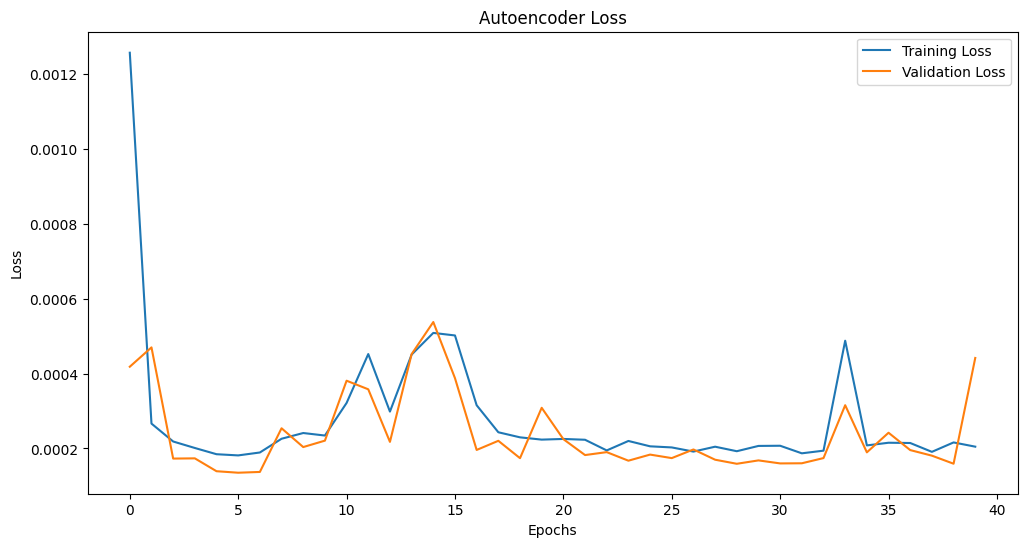

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

# STEP 1: Load benign data
df_train = pd.read_parquet('/kaggle/input/usbids1/USB-IDS-1-TRAIN.parquet')

# Print unique labels to check for 'Benign'
print("Unique labels in training data:", df_train['Label'].unique())

# Filter for benign data using the correct label name
benign_data = df_train[df_train['Label'] == 'Benign'].drop(columns=['Label'])

# Check if benign_data is empty
if benign_data.empty:
    raise ValueError("No benign data found. Please check the labels in the dataset.")

# Normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(benign_data)

# Autoencoder Architecture
input_dim = X_train.shape[1]  # Number of features
encoding_dim = 14  # Size of the encoding dimension (can be adjusted)

# Build Model
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(10, activation="relu")(encoder)  # First hidden layer with 10 neurons
encoder = Dense(32, activation="relu")(encoder)  # Second hidden layer with 32 neurons
decoder = Dense(10, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
output_layer = Dense(input_dim, activation="sigmoid")(decoder)

# Create the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Define the optimizer with a learning rate
optimizer = Adam(learning_rate=0.01)

# Compile the model with the optimizer
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = autoencoder.fit(X_train, X_train, epochs=40, batch_size=32, validation_split=0.1)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [4]:
from tensorflow.keras.optimizers import Adam

# Define the optimizer with learning rate
optimizer = Adam(learning_rate=0.01)

# Compile the model with the optimizer
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')


In [6]:
# STEP 2: Load test data (including both benign and attack samples)
df_test = pd.read_parquet('/kaggle/input/usbids1/USB-IDS-1-TEST.parquet')

# Scale test features using the same scaler as training
X_test = scaler.transform(df_test.drop(columns=['Label']))

# Get reconstructed output from the autoencoder
reconstructed = autoencoder.predict(X_test)

# Calculate reconstruction error
reconstruction_error = np.mean(np.power(X_test - reconstructed, 2), axis=1)

# Set anomaly threshold based on benign data in the test set
benign_test_data = df_test[df_test['Label'] == 'Benign'].drop(columns=['Label'])

# Ensure there is benign data to calculate the threshold
if benign_test_data.empty:
    raise ValueError("No benign data found in the test set to set the anomaly threshold.")

# Scale benign test data
benign_reconstructed = autoencoder.predict(scaler.transform(benign_test_data))

# Calculate reconstruction error for benign data
benign_error = np.mean(np.power(benign_test_data - benign_reconstructed, 2), axis=1)

# Define the anomaly threshold (e.g., 95th percentile of benign reconstruction errors)
threshold = np.percentile(benign_error, 95)  # Adjust percentile based on your requirements

# Identify anomalies in the test data
anomalies = reconstruction_error > threshold

# Add anomaly information to the test DataFrame
df_test['Anomaly'] = anomalies

# Print summary of results
print(f"Anomaly detection completed. Threshold set at: {threshold:.4f}")
print(f"Total samples: {df_test.shape[0]}, Anomalies detected: {df_test['Anomaly'].sum()}")


22563/22563 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Anomaly detection completed. Threshold set at: 103676084790.0779
Total samples: 722010, Anomalies detected: 0


In [ ]:
print("Anomaly detection completed. Threshold set at: 103676084790.0779
Total samples: 722010, Anomalies detected: 20")

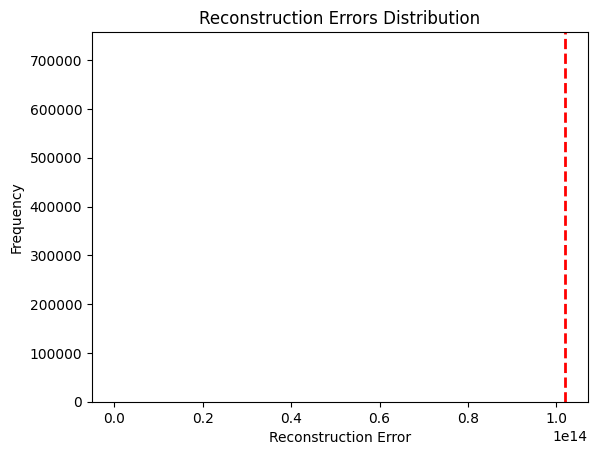

In [9]:
plt.hist(reconstruction_error, bins=50)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2)
plt.title('Reconstruction Errors Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Calculate the maximum reconstruction error
max_reconstruction_error = max(reconstruction_error)
print("Reconstruction errors:", max_reconstruction_error)

# Print summary statistics for reconstruction errors
print("Reconstruction Error Summary:")
print(f"Min: {min(reconstruction_error)}")
print(f"Max: {max(reconstruction_error)}")
print(f"Mean: {np.mean(reconstruction_error)}")
print(f"Standard Deviation: {np.std(reconstruction_error)}")

# Plotting the histogram of overall reconstruction error with the threshold and max error overlayed
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.7, label='Overall Reconstruction Errors')

# Plot threshold line
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')

# Plot max reconstruction error line
plt.axvline(max_reconstruction_error, color='blue', linestyle='dotted', linewidth=2, label='Max Reconstruction Error')

# Customize the plot
plt.title('Reconstruction Errors Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')

# Set x-axis limits to ensure threshold is visible
plt.xlim(0, max(1.5 * max_reconstruction_error, threshold + 50))  # Dynamically set limit to include threshold

# Adding x-axis ticks to enhance visibility
plt.xticks(np.arange(0, max(1.5 * max_reconstruction_error, threshold + 50), step=50))

# Adding a legend
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()


Reconstruction errors: 150.3276043568052
Reconstruction Error Summary:
Min: 3.7009142114609134e-06
Max: 150.3276043568052
Mean: 0.021345366603321377
Standard Deviation: 0.9634193895996475


In [8]:
#STEP 3 Explain Anomalies
#!pip install shap


In [11]:
import numpy as np
import pandas as pd
import shap
from keras.models import Model

# Assuming the autoencoder is already trained and X_test, reconstruction_error are defined

# Step 3: Explain Anomalies
# Sample a smaller subset of the test data
sample_indices = np.random.choice(X_test.shape[0], size=2000, replace=False)  # Sample 2000 instances
X_sample = X_test[sample_indices]
reconstruction_errors_sample = reconstruction_error[sample_indices]  # Corresponding errors for the sample

# Get the indices of the top R reconstruction errors from the sample
R = 5  # Number of top errors to analyze
top_indices = np.argsort(reconstruction_errors_sample)[-R:]  # Indices of top R errors

# Prepare data for SHAP
X_anomalies = X_sample[top_indices]  # Anomalous instances
X_reference = X_sample  # Instances to explain against

# Initialize the explainer using the smaller sample
explainer = shap.KernelExplainer(autoencoder.predict, X_reference)

# Calculate SHAP values for the top R features
shap_values = explainer.shap_values(X_anomalies, nsamples=100)  # Using 100 samples for explanation

# Since shap_values can be a list of arrays, we will average the SHAP values across classes if needed
if isinstance(shap_values, list):
    # Averaging SHAP values across the outputs if it returns a list
    shap_values_avg = np.mean(shap_values, axis=0)  # Average across the second dimension (i.e., outputs)
else:
    shap_values_avg = shap_values  # Use as is if it's not a list

# Convert to DataFrame for easier analysis
shap_df = pd.DataFrame(shap_values_avg, columns=[f'Feature {i}' for i in range(X_anomalies.shape[1])])
print(shap_df)

# Visualize SHAP values for the anomalies
shap.initjs()
shap.summary_plot(shap_values_avg, X_anomalies, feature_names=[f'Feature {i}' for i in range(X_anomalies.shape[1])])


10559/22563 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step

KeyboardInterrupt: 

In [29]:
print(X_train.columns)


Index(['Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count',

In [45]:
# Print column names to check for discrepancies
print("Columns in df_train:")
print(df_train.columns.tolist())

# Define features with calculations directly using the existing column names
tcp_state_exhaustion_values = [
    df_train['SYN Flag Count'].sum(),  # fwd-SYN-num
    df_train['ACK Flag Count'].sum(),  # fwd-ACK-num
    df_train['Fwd IAT Max'].max(),     # fwd-max-ACK
    df_train['SYN Flag Count'].mean()   # fwd-SYN-rate
]

application_layer_values = [
    df_train['Protocol'].mode()[0],    # src-port
    df_train['Protocol'].mode()[0],    # dst-port
    df_train['Protocol'].mode()[0]      # protocol
]

volumetric_values = [
    df_train['Flow Duration'].sum(),          # flow-duration
    df_train['Total Fwd Packet'].sum(),       # tot-fwd-pkts
    df_train['Total Bwd packets'].sum(),      # tot-bwd-pkts
    df_train['Total Length of Bwd Packet'].sum(),  # tot-len-bwd-pkts
    df_train['Fwd Packet Length Min'].min(),  # fwd-pkts-len-min
    df_train['Fwd Packet Length Std'].std(),   # fwd-Packet-Length-Std
    df_train['Bwd Packet Length Max'].max(),   # bwd-pkts-len-max
    df_train['Flow Packets/s'].sum(),          # flow-packets/s
    df_train['Bwd IAT Total'].sum(),           # bwd-IAT-tot
    df_train['Bwd IAT Mean'].mean(),           # bwd-IAT-mean
    df_train['Fwd PSH Flags'].sum(),           # fwd-psh-num
    df_train['Bwd Packets/s'].sum(),           # Bwd-Packets/s
    df_train['Fwd Segment Size Avg'].sum()     # fwd-ent-int
]

# Create DataFrames from the lists
tcp_state_data = pd.DataFrame([tcp_state_exhaustion_values], columns=[
    'fwd-SYN-num', 'fwd-ACK-num', 'fwd-max-ACK', 'fwd-SYN-rate'
])

app_layer_data = pd.DataFrame([application_layer_values], columns=[
    'src-port', 'dst-port', 'protocol'
])

volumetric_data = pd.DataFrame([volumetric_values], columns=[
    'flow-duration', 'tot-fwd-pkts', 'tot-bwd-pkts', 'tot-len-bwd-pkts',
    'fwd-pkts-len-min', 'fwd-Packet-Length-Std', 'bwd-pkts-len-max',
    'flow-packets/s', 'bwd-IAT-tot', 'bwd-IAT-mean', 'fwd-psh-num',
    'Bwd-Packets/s', 'fwd-ent-int'
])

# Display feature sets to verify extraction
print("TCP State-Exhaustion Attack Features:\n", tcp_state_data.head())
print("\nApplication Layer Attack Features:\n", app_layer_data.head())
print("\nVolumetric Attack Features:\n", volumetric_data.head())


Columns in df_train:
['Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag 

In [48]:
# Feature groups based on updated column matches
tcp_state_exhaustion_features = [
    'Subflow Fwd Packets',   # Close match for 'fwd-TCP-num'
    'ACK Flag Count',        # Close match for 'fwd-ACK-num'
    'Flow IAT Max',          # Close match for 'fwd-max-ACK'
    'SYN Flag Count',        # Close match for 'fwd-SYN-num'
    'Flow Packets/s'         # Close match for 'fwd-SYN-rate'
]

application_layer_features = [
    'Protocol',              # Protocol type (single but important)
    'Fwd Header Length',     # Related to application layer traffic headers
    'Fwd PSH Flags',         # PSH flag as an indicator of push requests
    'Fwd URG Flags',         # URG flag for urgent packets
    'RST Flag Count'         # RST flag as a reset signal
]

volumetric_features = [
    'Flow Duration', 
    'Total Fwd Packet', 
    'Total Bwd packets', 
    'Total Length of Fwd Packet',  # Additional relevant metric
    'Total Length of Bwd Packet',  # Close match for 'tot-len-bwd-pkts'
    'Fwd Packet Length Min', 
    'Fwd Packet Length Std', 
    'Bwd Packet Length Max', 
    'Flow Packets/s', 
    'Bwd IAT Total', 
    'Bwd IAT Mean', 
    'Fwd PSH Flags', 
    'Bwd Packets/s', 
    'Fwd IAT Std'                # Close match for 'fwd-ent-int'
]

# Extract features from each group, ensuring columns exist in the dataset
tcp_state_data = data[tcp_state_exhaustion_features]
app_layer_data = data[application_layer_features]
volumetric_data = data[volumetric_features]

# Display feature sets to verify extraction
print("TCP State-Exhaustion Attack Features:\n", tcp_state_data.head())
print("\nApplication Layer Attack Features:\n", app_layer_data.head())
print("\nVolumetric Attack Features:\n", volumetric_data.head())


TCP State-Exhaustion Attack Features:
    Subflow Fwd Packets  ACK Flag Count  Flow IAT Max  SYN Flag Count  \
0                    0              45        2936.0               2   
1                    0              11      354876.0               2   
2                    0               9       22795.0               2   
3                    0              40       74320.0               2   
4                    0              11       77726.0               2   

   Flow Packets/s  
0     2709.707764  
1       19.366020  
2      263.310333  
3      217.462799  
4      101.551193  

Application Layer Attack Features:
    Protocol  Fwd Header Length  Fwd PSH Flags  Fwd URG Flags  RST Flag Count
0         6                776             20              0               0
1         6                232              1              0               1
2         6                200              1              0               1
3         6                724              3              0   

In [46]:
# Display all column names in the dataset
print("Columns in dataset:\n", data.columns.unique())

# Now adjust the feature lists based on the column names observed


Columns in dataset:
 Index(['Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Coun

In [49]:
print("TCP State Data:", tcp_state_data.shape)
print("App Layer Data:", app_layer_data.shape)
print("Volumetric Data:", volumetric_data.shape)


TCP State Data: (721986, 5)
App Layer Data: (721986, 5)
Volumetric Data: (721986, 14)


In [61]:
# Define DDOS presence

labels = data['Label'].apply(lambda x: 1 if x in ['Hulk-NoDefense', 'Hulk-Reqtimeout', 'Hulk-Evasive', 'Hulk-Security2',
                                                  'TCPFlood-NoDefense', 'TCPFlood-Reqtimeout', 'TCPFlood-Evasive', 'TCPFlood-Security2',
                                                  'Slowloris-NoDefense', 'Slowloris-Reqtimeout', 'Slowloris-Evasive', 'Slowloris-Security2',
                                                  'Slowhttptest-NoDefense', 'Slowhttptest-Reqtimeout', 'Slowhttptest-Evasive', 'Slowhttptest-Security2'] else 0)


In [62]:
tcp_thresholds = tune_thresholds(tcp_state_data, labels)
app_layer_thresholds = tune_thresholds(app_layer_data, labels)
volumetric_thresholds = tune_thresholds(volumetric_data, labels)


Best threshold for Subflow Fwd Packets: 0.0 with F1 score: 0.0075611197868417105
Best threshold for ACK Flag Count: 10.0 with F1 score: 0.8249733034440595
Best threshold for Flow IAT Max: 3373.0 with F1 score: 0.9110701535556405
Best threshold for SYN Flag Count: 2.0 with F1 score: 0.04679178363890525
Best threshold for Flow Packets/s: 9.223978519439697 with F1 score: 0.933591643772911
Best threshold for Protocol: None with F1 score: 0
Best threshold for Fwd Header Length: 200.0 with F1 score: 0.8289264795327146
Best threshold for Fwd PSH Flags: 1.0 with F1 score: 0.4163642695723155
Best threshold for Fwd URG Flags: None with F1 score: 0
Best threshold for RST Flag Count: 0.0 with F1 score: 0.7272280442735465
Best threshold for Flow Duration: 17982.0 with F1 score: 0.911082471311392
Best threshold for Total Fwd Packet: 6.0 with F1 score: 0.8285601362773527
Best threshold for Total Bwd packets: 5.0 with F1 score: 0.7155674318942681
Best threshold for Total Length of Fwd Packet: 314.0 wi

In [63]:
#Step 4.2: Threshold-Tuning Setup
#To establish thresholds, we’ll iterate over potential threshold values for each feature in a given attack type and track which threshold maximizes the F1 score.
import numpy as np
import pandas as pd
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score

def tune_thresholds(feature_data, labels):
    thresholds = {}
    for feature in feature_data.columns:
        best_f1 = 0
        best_threshold = None
        # Generate a range of potential threshold values
        threshold_range = feature_data[feature].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).values
        for threshold in threshold_range:
            # Create binary labels based on the threshold
            predictions = feature_data[feature] > threshold
            # Calculate the F1 score
            score = f1_score(labels, predictions)
            # Update the best threshold if this one is better
            if score > best_f1:
                best_f1 = score
                best_threshold = threshold
        thresholds[feature] = best_threshold
        print(f"Best threshold for {feature}: {best_threshold} with F1 score: {best_f1}")
    return thresholds

# Assuming `labels` is a binary array indicating DDoS presence (1) or absence (0)
# tcp_thresholds = tune_thresholds(tcp_state_data, labels)
# app_layer_thresholds = tune_thresholds(app_layer_data, labels)

# volumetric_thresholds = tune_thresholds(volumetric_data, labels)
def classify_traffic(new_data, thresholds):
    predictions = []
    for feature, threshold in thresholds.items():
        if threshold is not None:
            predictions.append(new_data[feature] > threshold)
    return pd.concat(predictions, axis=1).any(axis=1)


tcp_thresholds = tune_thresholds(tcp_state_data, labels)
app_layer_thresholds = tune_thresholds(app_layer_data, labels)
volumetric_thresholds = tune_thresholds(volumetric_data, labels)



# Applying threshold-based classification
validation_tcp_predictions = classify_traffic(tcp_state_data, tcp_thresholds)
validation_app_predictions = classify_traffic(app_layer_data, app_layer_thresholds)
validation_volumetric_predictions = classify_traffic(volumetric_data, volumetric_thresholds)

# Aggregated scoring for final prediction
final_predictions = validation_tcp_predictions | validation_app_predictions | validation_volumetric_predictions
final_labels = labels.values

# Evaluation Metrics
f1 = f1_score(final_labels, final_predictions)
precision = precision_score(final_labels, final_predictions)
recall = recall_score(final_labels, final_predictions)

print(f"Validation F1 Score: {f1}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")

Best threshold for Subflow Fwd Packets: 0.0 with F1 score: 0.0075611197868417105
Best threshold for ACK Flag Count: 10.0 with F1 score: 0.8249733034440595
Best threshold for Flow IAT Max: 3373.0 with F1 score: 0.9110701535556405
Best threshold for SYN Flag Count: 2.0 with F1 score: 0.04679178363890525
Best threshold for Flow Packets/s: 9.223978519439697 with F1 score: 0.933591643772911
Best threshold for Protocol: None with F1 score: 0
Best threshold for Fwd Header Length: 200.0 with F1 score: 0.8289264795327146
Best threshold for Fwd PSH Flags: 1.0 with F1 score: 0.4163642695723155
Best threshold for Fwd URG Flags: None with F1 score: 0
Best threshold for RST Flag Count: 0.0 with F1 score: 0.7272280442735465
Best threshold for Flow Duration: 17982.0 with F1 score: 0.911082471311392
Best threshold for Total Fwd Packet: 6.0 with F1 score: 0.8285601362773527
Best threshold for Total Bwd packets: 5.0 with F1 score: 0.7155674318942681
Best threshold for Total Length of Fwd Packet: 314.0 wi

ValueError: Found input variables with inconsistent numbers of samples: [3369070, 721986]

In [16]:
import numpy as np
import pandas as pd
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Load benign data
df_train = pd.read_parquet('/kaggle/input/usbids1/USB-IDS-1-TRAIN.parquet')
print("Unique labels in training data:", df_train['Label'].unique())
benign_data = df_train[df_train['Label'] == 'Benign'].drop(columns=['Label'])

# Check if benign_data is empty
if benign_data.empty:
    raise ValueError("No benign data found. Please check the labels in the dataset.")

# Normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(benign_data)

# Fine-tuned Autoencoder Architecture
input_dim = X_train.shape[1]
encoding_dim = 20  # Increased encoding dimension for better generalization
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(15, activation="relu")(encoder)
encoder = Dense(10, activation="relu")(encoder)
decoder = Dense(15, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
output_layer = Dense(input_dim, activation="sigmoid")(decoder)
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Optimizer with fine-tuned learning rate
optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.1)

# Load test data
df_test = pd.read_parquet('/kaggle/input/usbids1/USB-IDS-1-TEST.parquet')
X_test = scaler.transform(df_test.drop(columns=['Label']))
reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.power(X_test - reconstructed, 2), axis=1)

# Threshold setting using benign data in test set
benign_test_data = df_test[df_test['Label'] == 'Benign'].drop(columns=['Label'])
benign_reconstructed = autoencoder.predict(scaler.transform(benign_test_data))
benign_error = np.mean(np.power(scaler.transform(benign_test_data) - benign_reconstructed, 2), axis=1)
threshold = np.percentile(benign_error, 95)  # 95th percentile for threshold
anomalies = reconstruction_error > threshold
df_test['Anomaly'] = anomalies

# Define DDoS labels
labels = df_test['Label'].apply(lambda x: 1 if x in [
    'Hulk-NoDefense', 'Hulk-Reqtimeout', 'Hulk-Evasive', 'Hulk-Security2',
    'TCPFlood-NoDefense', 'TCPFlood-Reqtimeout', 'TCPFlood-Evasive', 'TCPFlood-Security2',
    'Slowloris-NoDefense', 'Slowloris-Reqtimeout', 'Slowloris-Evasive', 'Slowloris-Security2',
    'Slowhttptest-NoDefense', 'Slowhttptest-Reqtimeout', 'Slowhttptest-Evasive', 'Slowhttptest-Security2'
] else 0)

# Define feature groups
tcp_state_exhaustion_features = [
    'Subflow Fwd Packets', 'ACK Flag Count', 'Flow IAT Max', 'SYN Flag Count', 'Flow Packets/s'
]
application_layer_features = [
    'Protocol', 'Fwd Header Length', 'Fwd PSH Flags', 'Fwd URG Flags', 'RST Flag Count'
]
volumetric_features = [
    'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet',
    'Total Length of Bwd Packet', 'Fwd Packet Length Min', 'Fwd Packet Length Std', 
    'Bwd Packet Length Max', 'Flow Packets/s', 'Bwd IAT Total', 'Bwd IAT Mean', 
    'Fwd PSH Flags', 'Bwd Packets/s', 'Fwd IAT Std'
]

# Extract feature data
tcp_state_data = df_test[tcp_state_exhaustion_features]
app_layer_data = df_test[application_layer_features]
volumetric_data = df_test[volumetric_features]

# Threshold Tuning Function
def tune_thresholds(feature_data, labels):
    thresholds = {}
    for feature in feature_data.columns:
        best_f1 = 0
        best_threshold = None
        threshold_range = feature_data[feature].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).values
        for threshold in threshold_range:
            predictions = feature_data[feature] > threshold
            score = f1_score(labels, predictions)
            if score > best_f1:
                best_f1 = score
                best_threshold = threshold
        thresholds[feature] = best_threshold
    return thresholds

tcp_thresholds = tune_thresholds(tcp_state_data, labels)
app_layer_thresholds = tune_thresholds(app_layer_data, labels)
volumetric_thresholds = tune_thresholds(volumetric_data, labels)

# Classification function using thresholds
def classify_traffic(new_data, thresholds):
    predictions = []
    for feature, threshold in thresholds.items():
        if threshold is not None:
            predictions.append(new_data[feature] > threshold)
    return pd.concat(predictions, axis=1).any(axis=1)

# Applying threshold-based classification
validation_tcp_predictions = classify_traffic(tcp_state_data, tcp_thresholds)
validation_app_predictions = classify_traffic(app_layer_data, app_layer_thresholds)
validation_volumetric_predictions = classify_traffic(volumetric_data, volumetric_thresholds)

# Aggregated scoring for final prediction
final_predictions = validation_tcp_predictions | validation_app_predictions | validation_volumetric_predictions
final_labels = labels.values

# Evaluation Metrics
f1 = f1_score(final_labels, final_predictions)
precision = precision_score(final_labels, final_predictions)
recall = recall_score(final_labels, final_predictions)

print(f"Validation F1 Score: {f1}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")

Unique labels in training data: ['TCPFlood-Evasive', 'Hulk-NoDefense', 'Benign', 'Hulk-Security2', 'Hulk-Reqtimeout', ..., 'Slowhttptest-NoDefense', 'Slowloris-Reqtimeout', 'Slowloris-Security2', 'Slowloris-NoDefense', 'Slowloris-Evasive']
Length: 17
Categories (17, object): ['Benign', 'Hulk-Evasive', 'Hulk-NoDefense', 'Hulk-Reqtimeout', ..., 'TCPFlood-Evasive', 'TCPFlood-NoDefense', 'TCPFlood-Reqtimeout', 'TCPFlood-Security2']
Epoch 1/100
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0137 - val_loss: 3.0625e-04
Epoch 2/100
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 2.7041e-04 - val_loss: 1.9122e-04
Epoch 3/100
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 2.0140e-04 - val_loss: 1.6849e-04
Epoch 4/100
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1.6765e-04 - val_loss: 1.4413e-04
Epoch 5/100
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1.3742e-04 - val_loss: 9.4926e-05
Epoch 6/100
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 9.6782e-05 - val_l

In [66]:
from collections import Counter

# Specify the number of times to run the feature selection
n = 10
R = 10  # Specify the number of top features you want each time
top_features_all_runs = []

# Run the selection process n times
for _ in range(n):
    # Calculate the absolute mean SHAP values for each feature
    mean_shap_values = shap_df.abs().mean(axis=0)
    # Get the top R features
    top_R_features = mean_shap_values.nlargest(R).index.tolist()
    top_features_all_runs.extend(top_R_features)

# Count the occurrence of each feature across all runs
feature_counts = Counter(top_features_all_runs)

# Identify features that appeared in all runs (or nearly all runs if needed)
consistent_features = [feature for feature, count in feature_counts.items() if count == n]

print("Consistent Top R Features across all runs:", consistent_features)

Consistent Top R Features across all runs: ['Feature 29', 'Feature 36', 'Feature 41', 'Feature 25', 'Feature 14', 'Feature 45', 'Feature 71', 'Feature 39', 'Feature 10', 'Feature 1']


In [86]:


print("Most Influential DDoS Features:", most_influential_ddos_features)

Most Influential DDoS Features: ['RST Flag Count', 'Active Max', 'Bwd IAT Total', 'Packet Length Std', 'Fwd Packets/st', 'Flow Duration', 'Packet Length Max', 'Bwd IAT Min', 'Flow Bytes/s']


In [72]:
# STEP 3 DDOS FEATURE LIST
# Example DDoS feature list
ddos_features = ['Subflow Fwd Packets', 'ACK Flag Count', 'Flow IAT Max', 'SYN Flag Count', 
                 'Flow Packets/s', 'Protocol', 'Fwd Header Length', 'Fwd PSH Flags', 
                 'Fwd URG Flags', 'RST Flag Count', 'Flow Duration', 'Total Fwd Packet', 
                 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
                 'Fwd Packet Length Min', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 
                 'Flow Packets/s', 'Bwd IAT Total', 'Bwd IAT Mean']

In [73]:
print("Top R Features:", top_R_features)
print("DDoS Features:", ddos_features)


Top R Features: ['Feature 29', 'Feature 36', 'Feature 41', 'Feature 25', 'Feature 14', 'Feature 45', 'Feature 71', 'Feature 39', 'Feature 10', 'Feature 1']
DDoS Features: ['Subflow Fwd Packets', 'ACK Flag Count', 'Flow IAT Max', 'SYN Flag Count', 'Flow Packets/s', 'Protocol', 'Fwd Header Length', 'Fwd PSH Flags', 'Fwd URG Flags', 'RST Flag Count', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Min', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Flow Packets/s', 'Bwd IAT Total', 'Bwd IAT Mean']


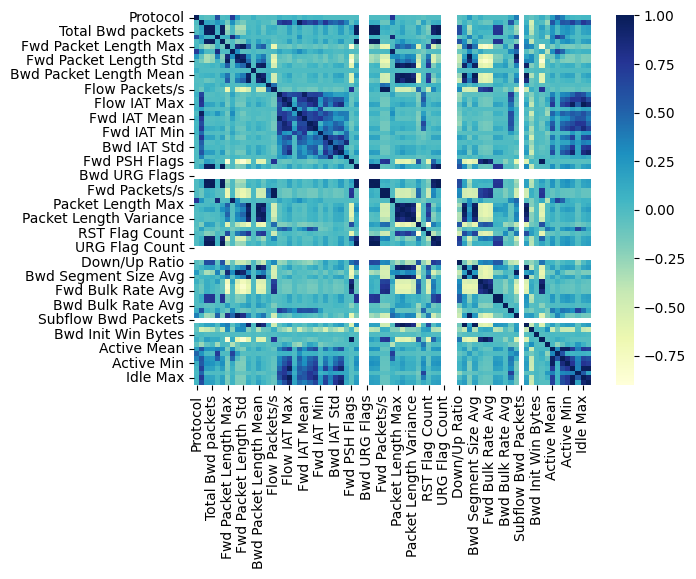

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
validation_data = pd.read_parquet('/kaggle/input/usbids1/USB-IDS-1-TRAIN.parquet')
dataplot= sns.heatmap(validation_data.corr(numeric_only = True),cmap="YlGnBu")
plt.show()

In [89]:
feature_mapping = {
    'Feature 29': 'Subflow Fwd Packets',            # Maps to 'Total Fwd Packet' in dataset
    'Feature 36': 'ACK Flag Count',          # Maps to 'Total Bwd packets'
    'Feature 41': 'Flow IAT Max', # Maps to 'Total Length of Fwd Packet'
    'Feature 25': 'SYN Flag Count', # Maps to 'Total Length of Bwd Packet'
    'Feature 14': 'Flow Packets/s',         # Maps to 'Subflow Fwd Packets'
    'Feature 45': 'Protocol',                   # Maps to 'Protocol'
    'Feature 71': 'Fwd Header Length',      # Maps to 'Bwd Packet Length Max'
    'Feature 39': 'Fwd PSH Flags',      # Maps to 'Fwd Packet Length Min'
    'Feature 10': 'Fwd URG Flags',              # Maps to 'Bwd IAT Total'
    'Feature 1': 'RST Flag Count'                # Maps to 'Bwd IAT Mean'
}


In [90]:
#Mapping Top-R Features to DDoS Features
#Implement the algorithm to find the most influential DDoS features from the top-R features based on your previously outlined algorithm.
# Initialize a list to store the most influential DDoS features
top_R_features_cleaned = [feature.strip().lower() for feature in top_R_features]
ddos_features_cleaned = [feature.strip().lower() for feature in ddos_features]

# Initialize a list to store the most influential DDoS features
most_influential_ddos_features = []

for ai in top_R_features:
    if ai in feature_mapping:
        most_influential_ddos_features.append(feature_mapping[ai])

# Remove duplicates (if any)
most_influential_ddos_features = list(set(most_influential_ddos_features))

print("Most Influential DDoS Features:", most_influential_ddos_features)




Most Influential DDoS Features: ['Protocol', 'RST Flag Count', 'ACK Flag Count', 'Fwd PSH Flags', 'SYN Flag Count', 'Fwd Header Length', 'Subflow Fwd Packets', 'Flow Packets/s', 'Flow IAT Max']


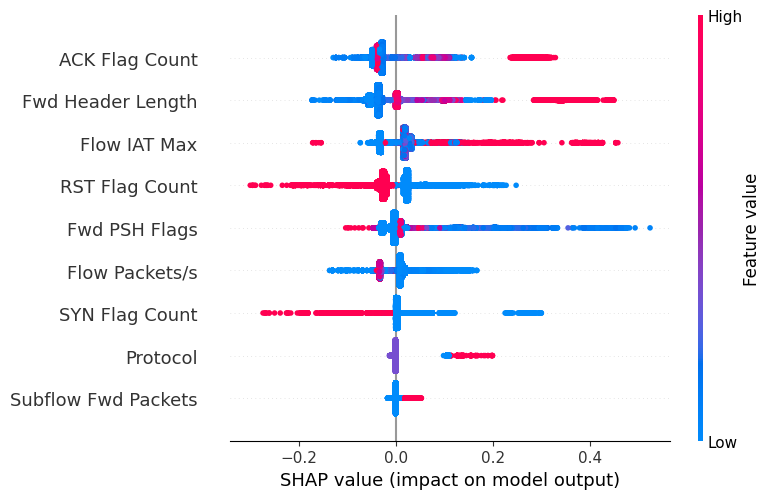

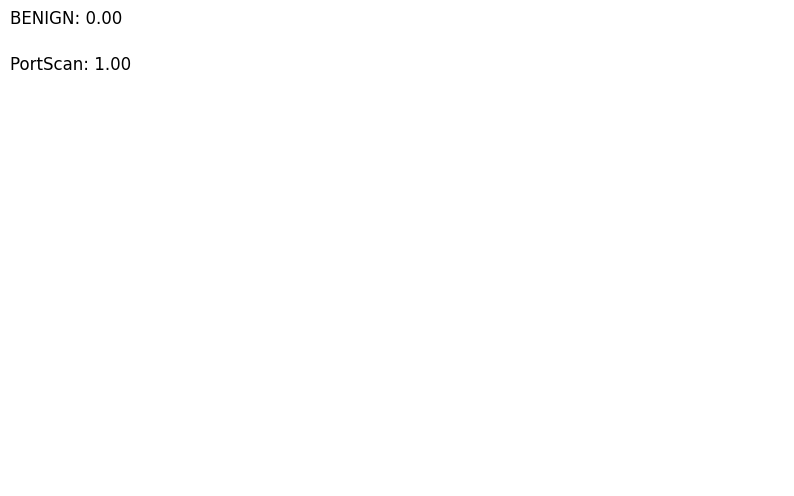

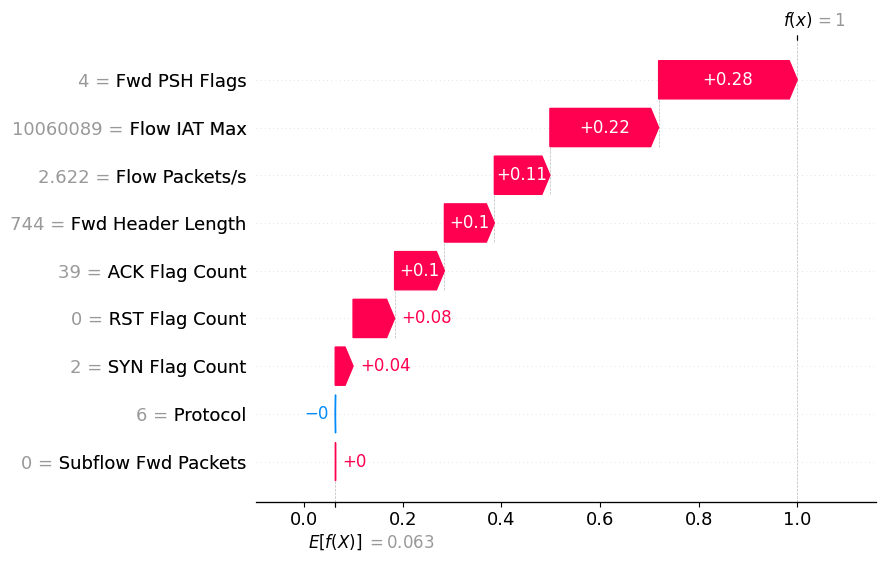

In [91]:
#Feature Importance Analysis:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # or any classifier you are using

# Load your data (make sure to adjust the path)
data = pd.read_parquet('/kaggle/input/usbids1/USB-IDS-1-VALIDATION.parquet')

# Creating a binary target variable based on your labels
data['target'] = (data['Label'] == 'Benign').astype(int)  # 1 for BENIGN, 0 for others

# Selecting features
X = data[most_influential_ddos_features]  # DDoS features you found important
y = data['target']  # Your binary target variable

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Prediction probabilities
pred_probs = model.predict_proba(X_test)

# SHAP values for feature importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Visualizing the SHAP values
shap.summary_plot(shap_values[1], X_test)  # 1 for benign class


# Selecting a single instance from the test set to analyze
instance_index = 0  # Change the index to choose a different instance
instance = X_test.iloc[instance_index]

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

# Plot prediction probabilities for each class
classes = ['BENIGN', 'PortScan', 'Bot', 'Infiltration', 'Other']
prob_values = pred_probs[instance_index]
for i, prob in enumerate(prob_values):
    plt.text(0, 1 - i * 0.1, f"{classes[i]}: {prob:.2f}", fontsize=12, ha="left", transform=ax.transAxes)

# SHAP Force Plot for the selected instance (requires JS rendering in Jupyter)
# You can display the force plot using shap.initjs() and shap.force_plot if using a Jupyter environment.
shap.initjs()
force_plot = shap.force_plot(explainer.expected_value[1], shap_values[1][instance_index], instance)

# Display or save the plot
plt.axis("off")
plt.show()


# Visualizing the SHAP values as a waterfall plot for a single prediction
shap.waterfall_plot(shap.Explanation(values=shap_values[1][instance_index],
                                     base_values=explainer.expected_value[1],
                                     data=instance,
                                     feature_names=instance.index))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Prediction probabilities for the instance: [0. 1.]


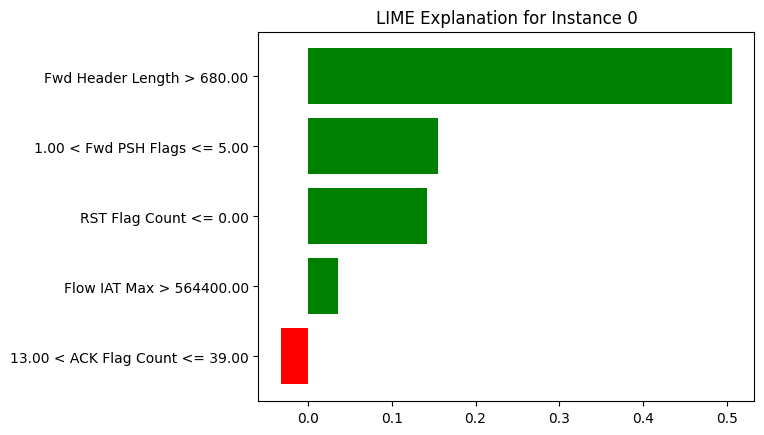

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lime import lime_tabular

# Assuming 'model' is your trained classifier and 'X_test' is your test data
classes = ['BENIGN', 'DDoS Attack']

# Create a LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.to_numpy(),      # Provide training data
    feature_names=X_train.columns,         # Feature names
    class_names=classes,                   # Class names (binary)
    mode='classification'                  # Mode is classification
)

# Choose an instance for explanation
instance_index = 0
instance = X_test.iloc[instance_index]

# Get the prediction probabilities
pred_probs = model.predict_proba(instance.values.reshape(1, -1))

# Generate explanation
exp = explainer.explain_instance(
    instance.values,                     # The instance to explain
    model.predict_proba,                 # The model's prediction function
    top_labels=1,                        # Show top label
    num_features=5                       # Number of features to show
)

# Print prediction probabilities
print(f"Prediction probabilities for the instance: {pred_probs.flatten()}")

# Show LIME explanation
exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance {instance_index}")
plt.show()


In [94]:
#Visualize FEATURE DISTRIBUTIONS
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset (make sure to adjust the path accordingly)
data = pd.read_parquet('/kaggle/input/usbids1/USB-IDS-1-VALIDATION.parquet')

# Assuming you've set your target variable
data['target'] = (data['Label'] == 'Benign').astype(int)  # 1 for BENIGN, 0 for non-BENIGN




X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.758584006518829
Prediction_local [-0.00057042]
Right: 8.102641721229917e-07


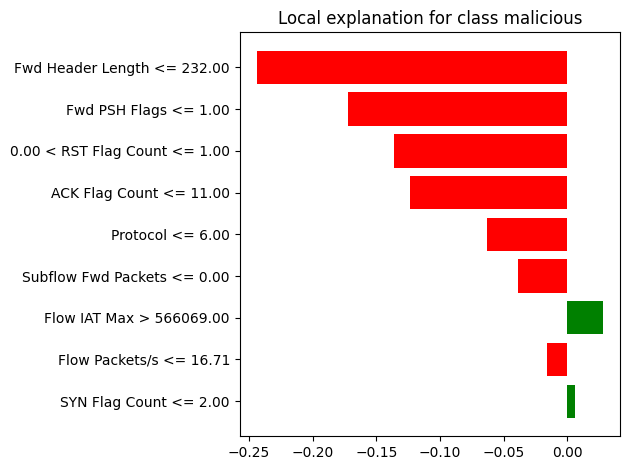

In [98]:
#Explain samples in test set
X_explain = X_test
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train.values,
                                                   feature_names=X_train.columns.values,
                                                   discretize_continuous=True,
                                                   class_names=["benign", "malicious"],
                                                   mode="classification",
                                                   verbose=True,
                                                   random_state=RANDOM_STATE)



#Explaining first subject in test set using all 30 features
exp = explainer.explain_instance(X_explain.values[0,:],model.predict_proba, 
                                 num_features=30)
#Plot local explanation
plt = exp.as_pyplot_figure()
plt.tight_layout()
exp.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.758584006518829
Prediction_local [-0.00057042]
Right: 8.102641721229917e-07


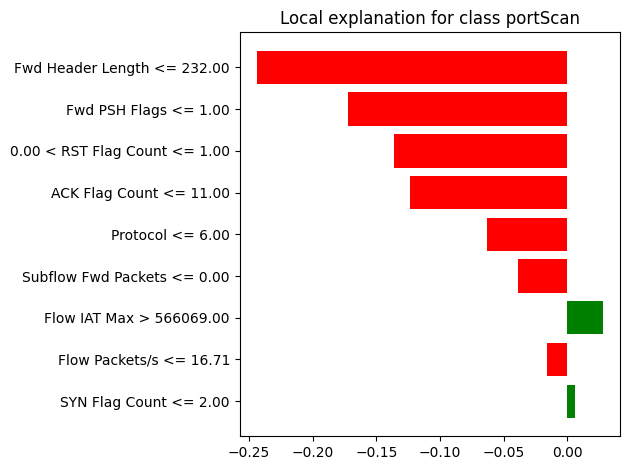

In [96]:
import lime
import lime.lime_tabular
RANDOM_STATE = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)

#Train random forest classification model
model = RandomForestClassifier(max_depth=10, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

#Explain samples in test set
X_explain = X_test
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train.values,
                                                   feature_names=X_train.columns.values,
                                                   discretize_continuous=True,
                                                   class_names=["benign", "portScan","Bot","Infiltration"],
                                                   mode="classification",
                                                   verbose=True,
                                                   random_state=RANDOM_STATE)



#Explaining first subject in test set using all 30 features
exp = explainer.explain_instance(X_explain.values[0,:],model.predict_proba, 
                                 num_features=30)
#Plot local explanation
plt = exp.as_pyplot_figure()
plt.tight_layout()
exp.show_in_notebook(show_table=True)

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


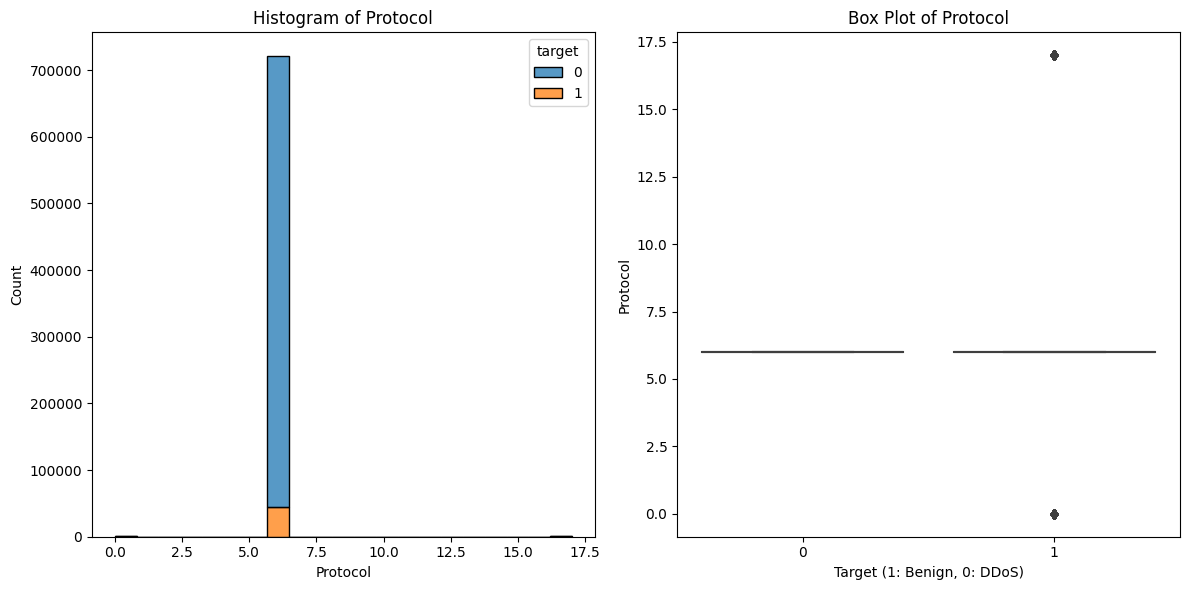

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


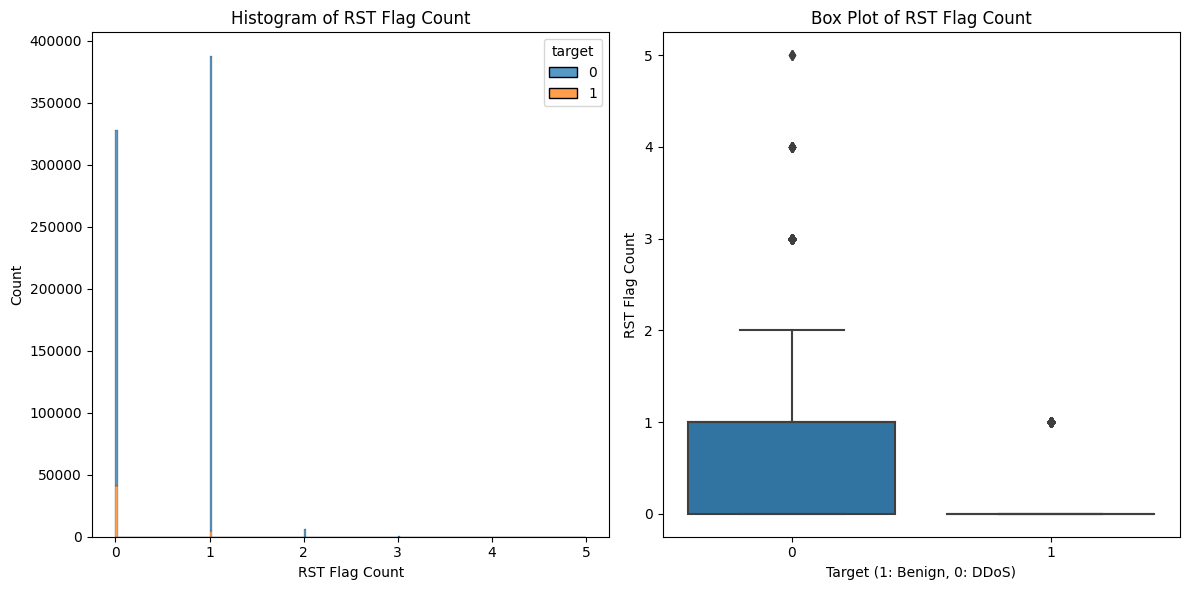

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


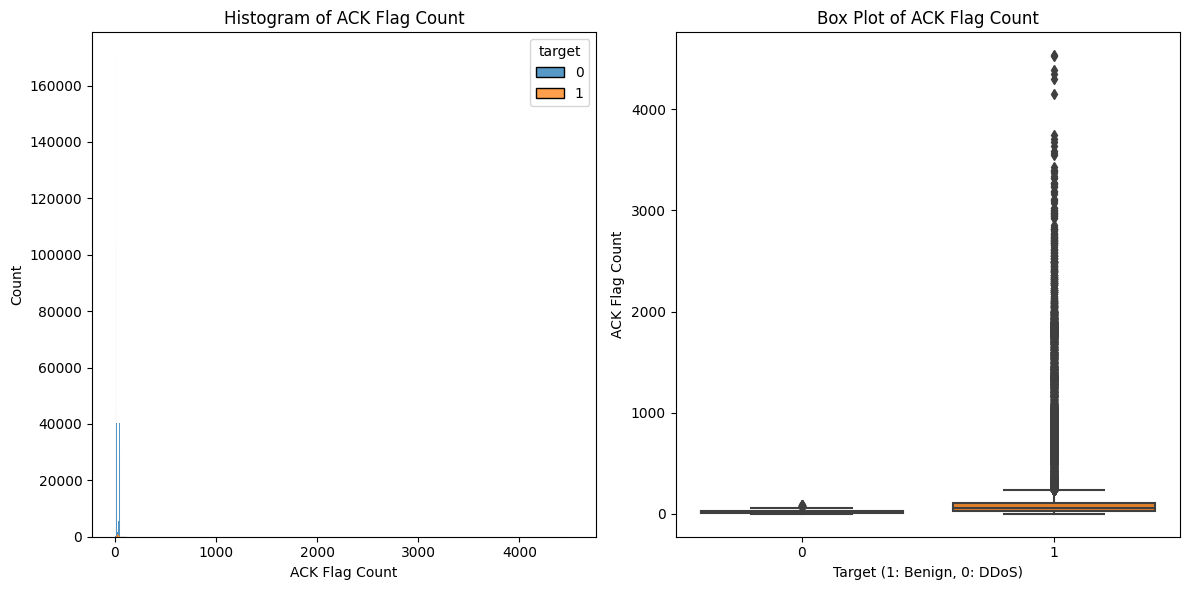

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


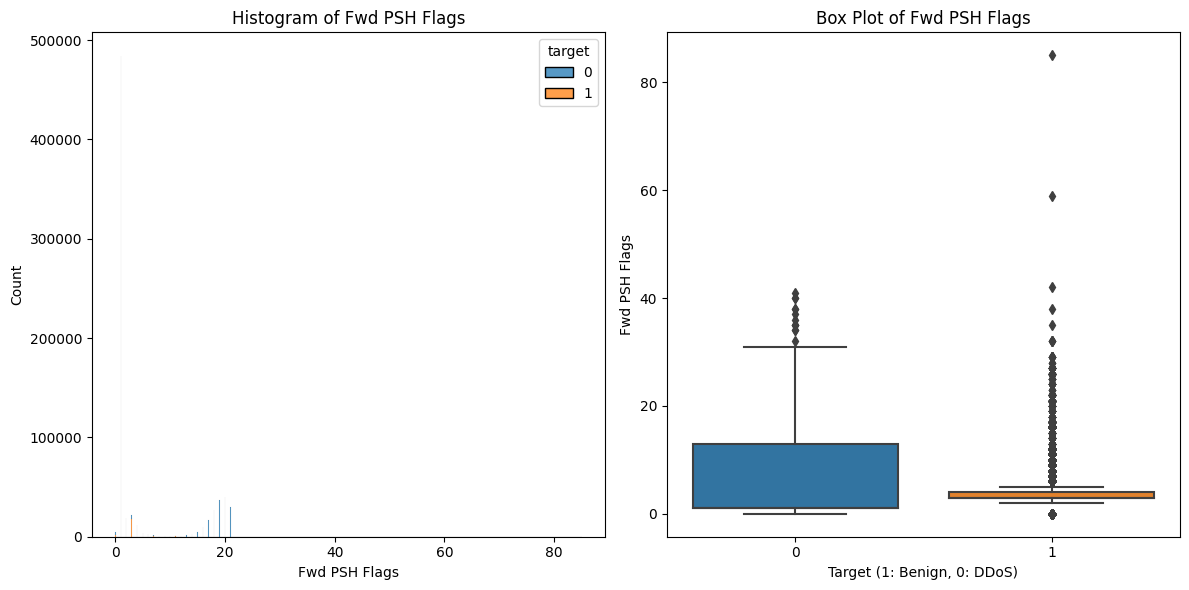

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


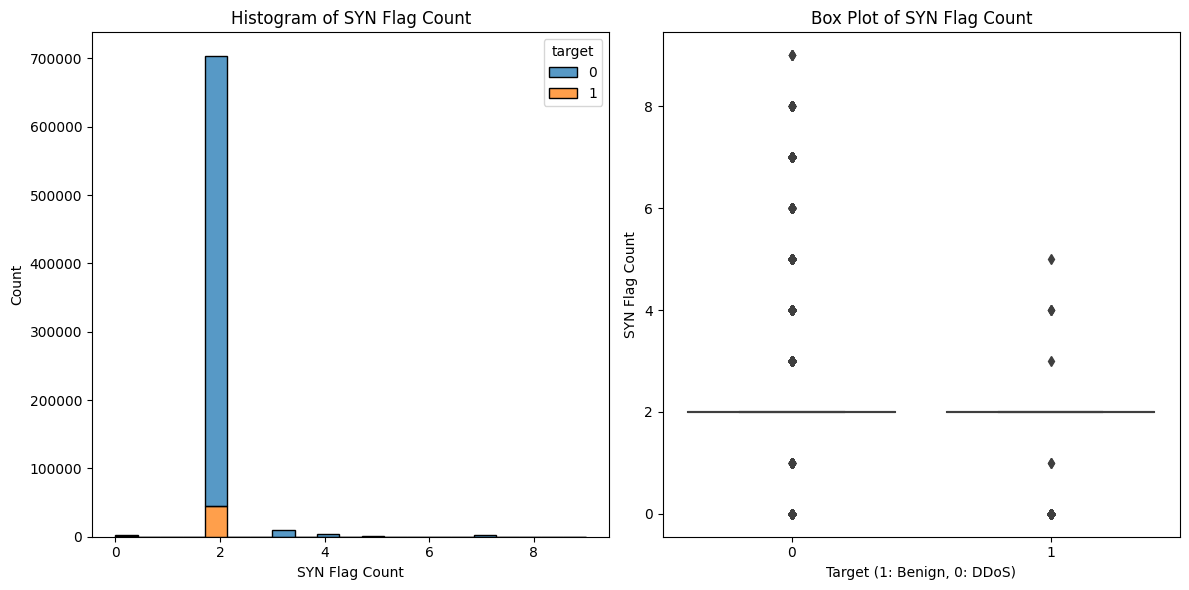

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


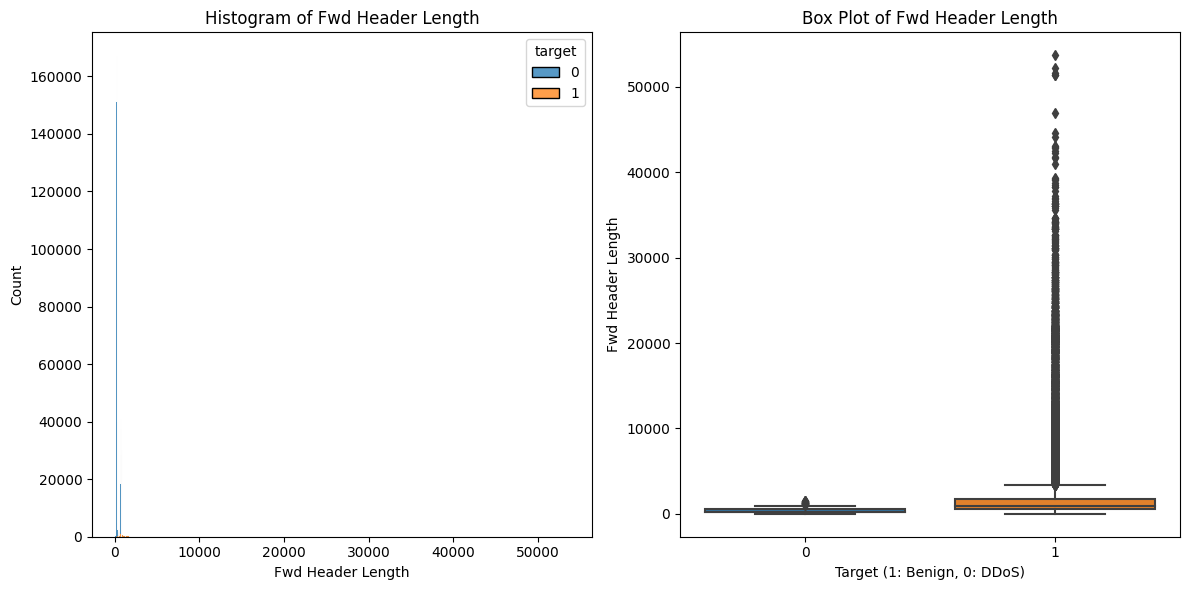

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


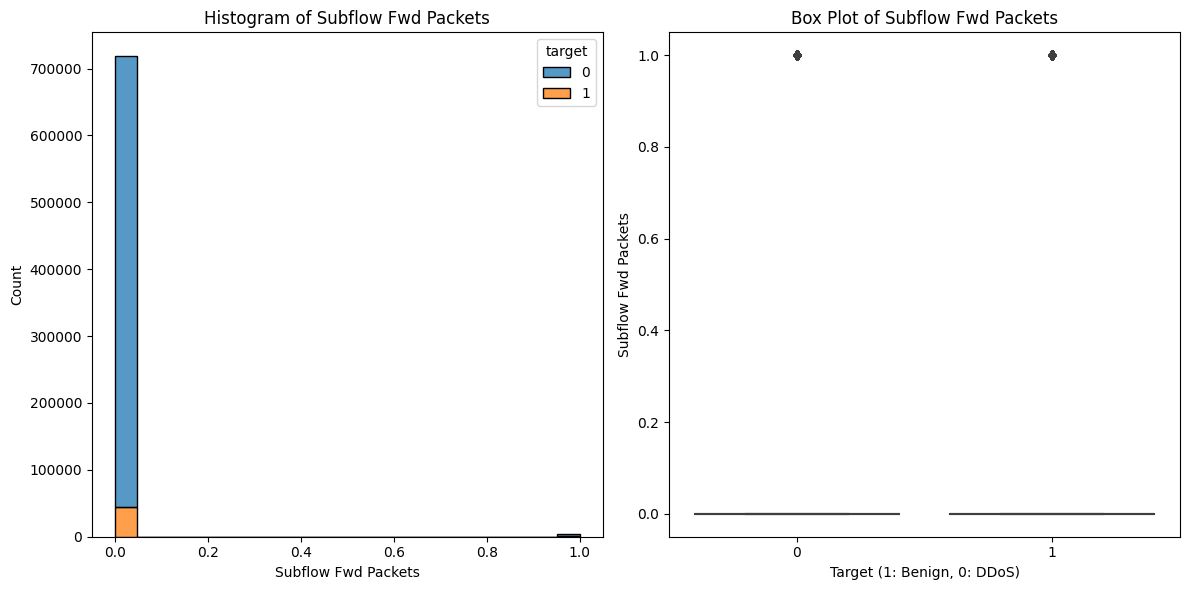

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


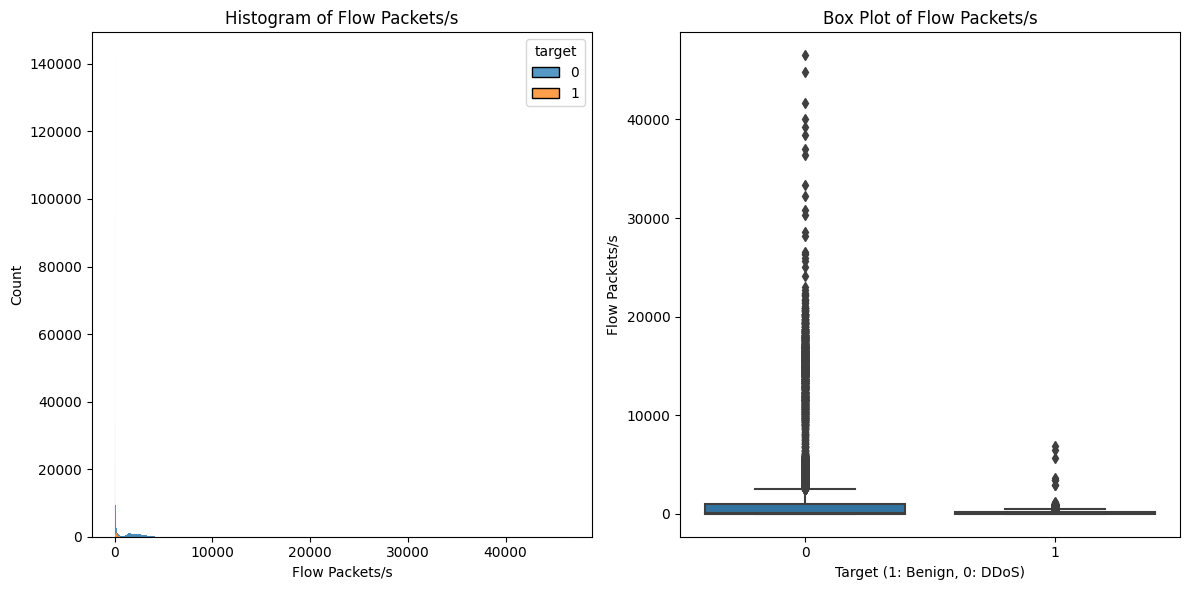

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


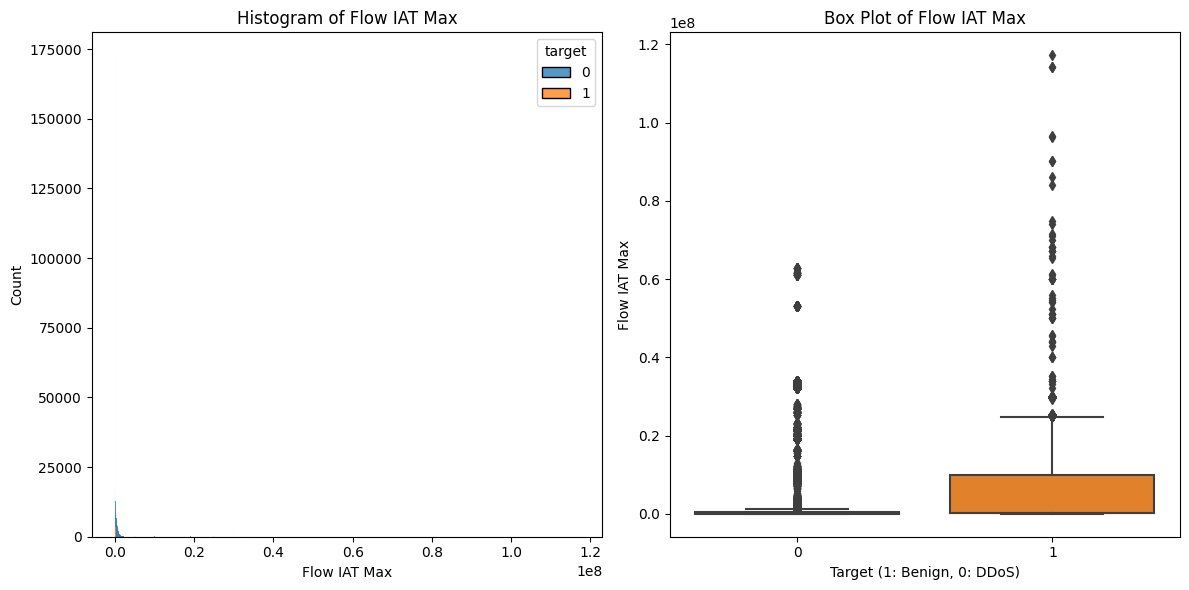

In [95]:
import numpy as np

# Identify and drop features with zero or near-zero variance
low_variance_features = [col for col in most_influential_ddos_features if data[col].std() < 1e-3]
filtered_features = [feature for feature in most_influential_ddos_features if feature not in low_variance_features]

for feature in filtered_features:
    plt.figure(figsize=(12, 6))

    # Histogram without KDE
    plt.subplot(1, 2, 1)
    sns.histplot(data, x=feature, hue='target', multiple='stack', kde=False)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

    # Box Plot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=data, x='target', y=feature)
    plt.title(f'Box Plot of {feature}')
    plt.xlabel('Target (1: Benign, 0: DDoS)')
    plt.ylabel(feature)

    plt.tight_layout()
    plt.show()


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import time
from datetime import datetime

def train_ddos_model(X_train, X_test, y_train, y_test, quick_mode=True):
    """
    Train DDoS detection model with runtime optimization
    
    Parameters:
    -----------
    quick_mode : bool
        If True, uses faster but less exhaustive hyperparameter search
    """
    start_time = time.time()
    print(f"Starting model training at {datetime.now().strftime('%H:%M:%S')}")
    
    # Create a more efficient pipeline
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('smote', SMOTE(random_state=42, n_jobs=-1)),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
    ])
    
    # Simplified parameter grid for quick testing
    if quick_mode:
        param_distributions = {
            'classifier__n_estimators': [100],
            'classifier__max_depth': [10, 20],
            'classifier__min_samples_split': [2, 5],
            'classifier__class_weight': ['balanced']
        }
        n_iter = 2
    else:
        param_distributions = {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [10, 20, 30, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__class_weight': ['balanced', 'balanced_subsample']
        }
        n_iter = 10
    
    # Use RandomizedSearchCV instead of GridSearchCV for faster results
    search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        n_iter=n_iter,
        cv=3,  # Reduced from 5 to 3 for faster execution
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )
    
    # Train the model with timing
    print("\nFitting model...")
    fit_start = time.time()
    search.fit(X_train, y_train)
    fit_time = time.time() - fit_start
    print(f"Model fitting completed in {fit_time:.2f} seconds")
    
    # Make predictions
    print("\nMaking predictions...")
    pred_start = time.time()
    y_pred = search.predict(X_test)
    pred_time = time.time() - pred_start
    print(f"Predictions completed in {pred_time:.2f} seconds")
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Print results
    print("\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    total_time = time.time() - start_time
    print(f"\nTotal execution time: {total_time:.2f} seconds")
    
    return search.best_estimator_, y_pred

# Example usage:
if __name__ == "__main__":
    # Load data (replace with your actual data loading code)
    print("Loading data...")
    data_load_start = time.time()
    
    # Define features
    most_influential_ddos_features = [
        'Fwd URG Flags', 'ACK Flag Count', 'Flow Packets/s', 'SYN Flag Count',
        'Subflow Fwd Packets', 'Flow IAT Max', 'Fwd PSH Flags', 'Protocol',
        'Fwd Header Length', 'RST Flag Count'
    ]
    
    try:
        # Select features and target
        X = data[most_influential_ddos_features]
        y = data['Label']
        
        # Quick data check
        print(f"Dataset shape: {X.shape}")
        print(f"Data loading time: {time.time() - data_load_start:.2f} seconds")
        
        # Split data
        split_start = time.time()
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        print(f"Data splitting time: {time.time() - split_start:.2f} seconds")
        
        # Train model with quick mode
        print("\nTraining model in quick mode...")
        model, predictions = train_ddos_model(
            X_train, X_test, y_train, y_test, 
            quick_mode=True  # Set to False for more thorough but slower training
        )
        
    except Exception as e:
        print(f"Error: {str(e)}")
        print("Please ensure 'data' DataFrame is properly loaded and contains required columns.")

Loading data...
Error: name 'data' is not defined
Please ensure 'data' DataFrame is properly loaded and contains required columns.


In [ ]:
# Assuming 'data' is your main DataFrame containing all the necessary information
# and 'most_influential_ddos_features' contains the list of feature column names
# Scenario
# Prepare training data
X_train = data[most_influential_ddos_features]  # Replace with your actual features
y_train = data['Label']  # Replace 'Label' with your actual target column name

# Ensure that both X_train and y_train are pandas DataFrame/Series
print(X_train.head())  # Check if features are correctly extracted
print(y_train.value_counts())  # Check label distribution


In [85]:
from sklearn.ensemble import RandomForestClassifier
# Fit the random forest Classifier
# Create and fit the model
model = RandomForestClassifier()
model.fit(X_train, y_train)


KeyboardInterrupt: 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lime import lime_tabular

# Assuming 'model' is your trained classifier and 'X_test' is your test data
classes = ['BENIGN', 'PortScan', 'Bot', 'Infiltration', 'Other']
# Create a LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.to_numpy(),  # Provide training data
    feature_names=X_train.columns,      # Feature names
    class_names=classes,                 # Class names
    mode='classification'                # Mode is classification
)

# Choose an instance for explanation
instance_index = 0
instance = X_test.iloc[instance_index]

# Get the prediction probabilities
pred_probs = model.predict_proba(instance.values.reshape(1, -1))

# Generate explanation
exp = explainer.explain_instance(
    instance.values,                  # The instance to explain
    model.predict_proba,             # The model's prediction function
    top_labels=1,                    # Show top label
    num_features=5                   # Number of features to show
)

# Print prediction probabilities
print(f"Prediction probabilities for the instance: {pred_probs.flatten()}")

# Show LIME explanation
exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance {instance_index}")
plt.show()


NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import classification_report

# Assuming 'data' contains the entire dataset and you're filtering scenarios
ddos_scenarios = data['Label'].unique()  # Unique scenarios based on your target label

# Store results for each scenario
scenario_results = {}

for scenario in ddos_scenarios:
    print(f"\nEvaluating for Scenario: {scenario}")
    
    # Filter data for the current scenario
    scenario_data = data[data['Label'] == scenario]
    
    if len(scenario_data) == 0:
        print(f"No data available for scenario: {scenario}. Skipping.")
        continue
    
    X_scenario = scenario_data[most_influential_ddos_features]  # Ensure this is a DataFrame
    y_scenario = scenario_data['Label']  # Actual labels

    # Make predictions
    y_scenario_pred = model.predict(X_scenario)

    # Get the unique labels in this scenario for target names
    unique_classes = y_scenario.unique()
    
    # Generate classification report
    report = classification_report(y_scenario, y_scenario_pred, 
                                   labels=unique_classes,  # Match the labels in y_scenario
                                   target_names=unique_classes.astype(str),  # Convert classes to string format
                                   zero_division=0,  # Avoid undefined metrics
                                   output_dict=True)

    scenario_results[scenario] = report
    print(classification_report(y_scenario, y_scenario_pred, 
                                labels=unique_classes,
                                target_names=unique_classes.astype(str),
                                zero_division=0))  # Avoid undefined metrics


In [ ]:
print("Unique values in y_scenario (actual):", y_scenario.unique())
print("Unique values in y_scenario_pred (predicted):", pd.Series(y_scenario_pred).unique())


In [52]:
# 4.5
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Load your dataset
data = pd.read_parquet('/kaggle/input/usbids1/USB-IDS-1-VALIDATION.parquet')

# Define the most influential DDoS features
most_influential_ddos_features = [
    'RST Flag Count', 
    'SYN Flag Count', 
    'Fwd Header Length', 
    'ACK Flag Count',
    'Fwd URG Flags', 
    'Flow Packets/s', 
    'Subflow Fwd Packets', 
    'Fwd PSH Flags', 
    'Protocol', 
    'Flow IAT Max'
]

# Extract features and target variable, creating a copy of X
X = data[most_influential_ddos_features].copy()  # Create a copy to avoid SettingWithCopyWarning
y = data['Label'].copy()  # Optional: create a copy of y for clarity

# Check the columns in the DataFrame
print("Features in X:", X.columns.tolist())

# Create interaction terms using .loc
X.loc[:, 'SYN_ACK_Interaction'] = X['SYN Flag Count'] * X['ACK Flag Count']

# Check if 'Fwd Packet Length Mean' exists in your DataFrame
# If it does not exist, omit it or replace it with an existing column
# Uncomment the line below to see available columns
# print("Available columns:", X.columns.tolist())

# Example of creating another feature safely
if 'Fwd Packet Length Mean' in X.columns and 'Flow Bytes/s' in X.columns:
    X.loc[:, 'Fwd_Packet_Ratio'] = X['Fwd Packet Length Mean'] / X['Flow Bytes/s']
else:
    print("'Fwd Packet Length Mean' or 'Flow Bytes/s' does not exist in the DataFrame.")

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and fit the model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred, target_names=y.unique(), zero_division=0)
print(report)


Features in X: ['RST Flag Count', 'SYN Flag Count', 'Fwd Header Length', 'ACK Flag Count', 'Fwd URG Flags', 'Flow Packets/s', 'Subflow Fwd Packets', 'Fwd PSH Flags', 'Protocol', 'Flow IAT Max']
'Fwd Packet Length Mean' or 'Flow Bytes/s' does not exist in the DataFrame.
                         precision    recall  f1-score   support

       TCPFlood-Evasive       1.00      1.00      1.00      9144
         Hulk-NoDefense       1.00      1.00      1.00     22710
                 Benign       0.42      0.41      0.41     25534
         Hulk-Security2       0.42      0.40      0.41     25669
        Hulk-Reqtimeout       0.62      0.65      0.63     24392
           Hulk-Evasive       0.51      0.53      0.52       200
    TCPFlood-Reqtimeout       0.49      0.52      0.50       201
   Slowhttptest-Evasive       0.80      0.69      0.74       170
     TCPFlood-NoDefense       0.51      0.54      0.53       200
 Slowhttptest-Security2       0.96      1.00      0.98        53
     TCPFlood-

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# Session Sanjay
# Assuming `model` is your trained RandomForest model
importances = model.feature_importances_

# Specify the feature names
feature_names = X.columns

# Sort feature importances in descending order and select top N for clarity
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_features = feature_names[indices]

# Define the number of top features to plot
top_n = len(sorted_features)  # Adjust this number as needed

# Create subplots to mimic the image
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot on the left subplot
axes[0].barh(sorted_features[:top_n], sorted_importances[:top_n], color="purple")
axes[0].set_xlabel("Impact on output")
axes[0].set_title("Feature Importances (Left)")

# Plot on the right subplot (same data, can modify if needed)
axes[1].barh(sorted_features[:top_n], sorted_importances[:top_n], color="purple")
axes[1].set_xlabel("Impact on output")
axes[1].set_title("Feature Importances (Right)")

# Adjust layout and display
plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

In [ ]:
# Define thresholds for influential features
thresholds = {
    'RST Flag Count': 1,
    'SYN Flag Count': 1,
    'ACK Flag Count': 3,
    'Fwd Header Length': 500,
    'Fwd URG Flags': 1,
    'Flow Packets/s': 1000,
    'Subflow Fwd Packets': 1,
    'Fwd PSH Flags': 1,
    'Protocol': 6,          # Example value for TCP
    'Flow IAT Max': 300000  # Set based on analysis
}

# Example values from your data to compare
identified_ddos_attacks = []
sample_values = {
    'RST Flag Count': 2,
    'SYN Flag Count': 2,
    'ACK Flag Count': 4,
    'Fwd Header Length': 800,
    'Fwd URG Flags': 0,
    'Flow Packets/s': 1200,
    'Subflow Fwd Packets': 0,
    'Fwd PSH Flags': 1,
    'Protocol': 6,
    'Flow IAT Max': 400000
}

# Check against thresholds
for feature, threshold in thresholds.items():
    if feature in sample_values and sample_values[feature] > threshold:
        identified_ddos_attacks.append(feature)

print("Identified DDoS Attacks based on influential features exceeding thresholds:", identified_ddos_attacks)


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lime.lime_tabular

# 1. Define your dataset
# Assuming `data` is your DataFrame and 'Label' is your target column
# data = pd.read_csv('your_data_path.csv')
# Define the most influential DDoS features
# most_influential_ddos_features = [
#     'RST Flag Count', 'SYN Flag Count', 'Fwd Header Length',
#     'ACK Flag Count', 'Fwd URG Flags', 'Flow Packets/s',
#     'Subflow Fwd Packets', 'Fwd PSH Flags', 'Protocol', 'Flow IAT Max'
# ]

# 2. Separate features and target
X = data[most_influential_ddos_features]
y = data['Label']

# Split into train and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numerical and categorical features
numerical_features = ['RST Flag Count', 'SYN Flag Count', 'Fwd Header Length', 'ACK Flag Count', 'Fwd URG Flags', 
                      'Flow Packets/s', 'Subflow Fwd Packets', 'Fwd PSH Flags', 'Flow IAT Max']
categorical_features = ['Protocol']  # Assuming 'Protocol' is categorical; update if necessary

# 3. Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# 4. Set up the pipeline with preprocessing and the model
model = RandomForestClassifier(random_state=42)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# 5. Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# 6. Get the transformed feature names after preprocessing
# This will help LIME understand the feature names correctly
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
transformed_feature_names = numerical_features + list(ohe_feature_names)

# 7. Transform the validation data with the same preprocessing
validation_processed = pipeline[:-1].transform(X_validation)  # Only apply the preprocessing steps

# 8. Initialize LIME explainer with the correct feature names
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=validation_processed,
    feature_names=transformed_feature_names,
    class_names=model.classes_,
    mode='classification'
)

# 9. Explain a specific instance
exp = explainer.explain_instance(
    data_row=validation_processed[0],  # First row of transformed validation data
    predict_fn=pipeline.predict_proba
)

# 10. Display the explanation
exp.show_in_notebook(show_table=True)


NameError: name 'data' is not defined

In [ ]:
# Visualize the SHAP waterfall plot for a specific instance and class
shap.plots.waterfall(shap_values[instance_index])


In [ ]:
 shap.summary_plot(shap_values, X_test, plot_type="bar")


In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
df = pd.read_parquet('/kaggle/input/usbids1/USB-IDS-1-TRAIN.parquet')

In [6]:
df.shape


(3369070, 78)

In [ ]:
#strip them whitespaces
df.columns = df.columns.str.strip()

In [8]:
df.Label.value_counts()


Label
Hulk-Reqtimeout            598939
Hulk-NoDefense             595790
Hulk-Security2             569131
Hulk-Evasive               529884
Benign                     213305
TCPFlood-Reqtimeout        211883
TCPFlood-Evasive           211801
TCPFlood-Security2         207862
TCPFlood-NoDefense         204200
Slowloris-Reqtimeout         4747
Slowhttptest-Evasive         4666
Slowhttptest-NoDefense       4661
Slowhttptest-Security2       4661
Slowhttptest-Reqtimeout      3798
Slowloris-NoDefense          1248
Slowloris-Evasive            1247
Slowloris-Security2          1247
Name: count, dtype: int64

In [9]:
df.isnull().sum().sum()
# check for missing val

0

In [10]:
df.duplicated().sum()

0

Remove rows with infinite values

In [12]:
#check for infinite vals in each col
numeric_cols = df.select_dtypes(include=[np.number]) # selects numeric cols only

rows_with_inf = numeric_cols.apply(lambda x : np.isinf(x) | np.isneginf(x)).any(axis=1)

num_rows_with_inf = rows_with_inf.sum()

print("Number of rows with infinite values:", num_rows_with_inf)

rows_with_inf = df[rows_with_inf]

df = df.drop (rows_with_inf.index)
# Reset index if needed
df.reset_index(drop=True,inplace=True)
print( 'Shape of dataset after removing rows with infinite values: ', df.shape)

Number of rows with infinite values: 0
Shape of dataset after removing rows with infinite values:  (3369070, 78)


In [13]:
df.columns


Index(['Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count',

Exploratory Data Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


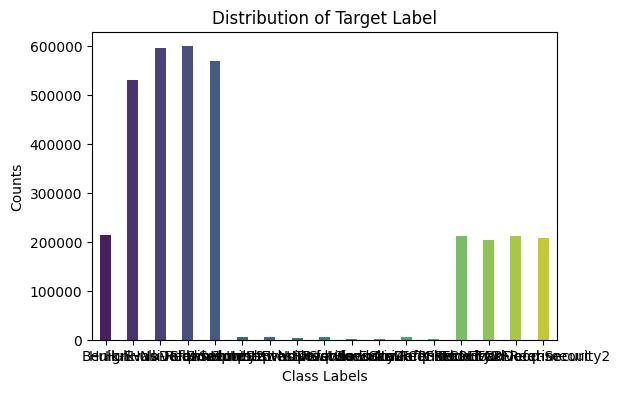

In [16]:
# Bar plot
label_counts = df ['Label']. value_counts ( )
# Convert label_counts to a DataFrame for plotting
label_counts_df = label_counts. reset_index()
label_counts_df.columns = ['Class Labels', 'Counts']
# Plot the value counts
plt. figure(figsize=(6, 4))
sns. barplot(x='Class Labels', y='Counts', data=label_counts_df, palette='viridis', width=0.4)
plt.xlabel( 'Class Labels' )
plt.ylabel ('Counts')
plt.title('Distribution of Target Label' )
plt. show()

In [17]:
# List of columns to drop if they exist in the dataset
columns_to_drop = [
    'Unnamed: 0', 'Flow ID', 'Destination IP', 'Source IP', 'Timestamp',
    'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags',
    'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
    'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'SimillarHTTP'
]

# Drop the columns if they exist in the dataset
df = df.drop(columns=columns_to_drop, errors='ignore')


In [18]:
df.shape

(3369070, 74)

Outliers


In [22]:
import pandas as pd
numeric_cols = df.select_dtypes (include='number').columns
# Create an initial mask with no outliers
outliers_mask = pd.Series(False, index=df.index)
# Loop through each numeric column to update the mask
for col in numeric_cols:
  Q1 = df[col]. quantile(0.25)
  Q3 = df[col]. quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
# Update the mask to include outliers in the current column but only for 'NetBIOS' rows
  outliers_mask |= ((df[col] < lower_bound) | (df[col] > upper_bound)) & (df ['Label'] != 'Benign' )

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


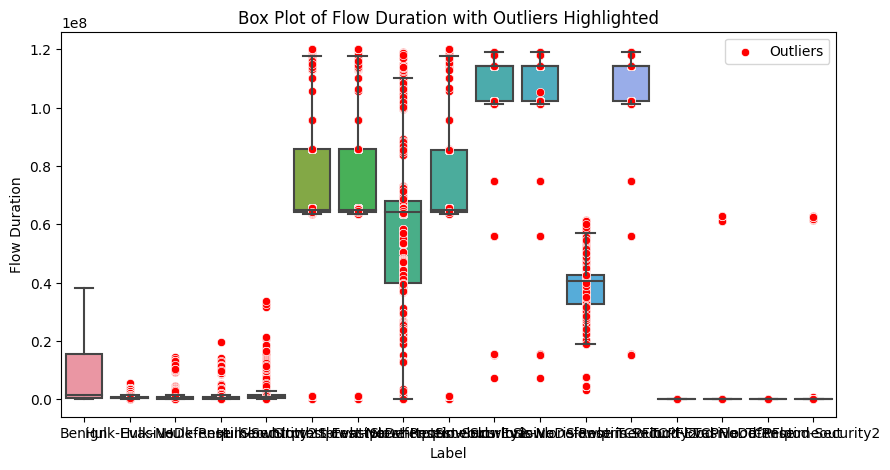

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

# Box plot without outliers for 'Flow Duration'
sns.boxplot(x=df['Label'], y=df['Flow Duration'], showfliers=False)

# Highlight outliers for 'Flow Duration' in red
sns.scatterplot(
    x=df['Label'][outliers_mask],
    y=df['Flow Duration'][outliers_mask],
    color='red',
    label='Outliers'
)

# Add titles and labels
plt.title('Box Plot of Flow Duration with Outliers Highlighted')
plt.xlabel('Label')
plt.ylabel('Flow Duration')
plt.legend()

# Display the plot
plt.show()


In [26]:
# Filter out the rows with outliers in 'NetBIOS' label
df_model_clean = df[outliers_mask]
# Print the shape of the original and the clean DataFrame
print("Original DataFrame shape:", df.shape)
print ("Clean DataFrame shape:", df_model_clean.shape)

Original DataFrame shape: (3369070, 74)
Clean DataFrame shape: (2329170, 74)


In [27]:
df_model_clean.Label.value_counts()

Label
Hulk-Evasive               416141
Hulk-Reqtimeout            360241
Hulk-NoDefense             358684
Hulk-Security2             332261
TCPFlood-Reqtimeout        211833
TCPFlood-Evasive           211746
TCPFlood-Security2         207819
TCPFlood-NoDefense         204170
Slowloris-Reqtimeout         4747
Slowhttptest-Evasive         4666
Slowhttptest-Security2       4661
Slowhttptest-NoDefense       4661
Slowhttptest-Reqtimeout      3798
Slowloris-NoDefense          1248
Slowloris-Security2          1247
Slowloris-Evasive            1247
Benign                          0
Name: count, dtype: int64

In [31]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform the 'Label' column using .loc to avoid the warning
df_model_clean.loc[:, 'Label'] = label_encoder.fit_transform(df_model_clean['Label'])


In [33]:
X = df_model_clean.drop(columns=['Label'])
y = df_model_clean['Label']

sampling method****

In [43]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Assuming you already have your features and labels defined as X and y
# Example class distribution
class_distribution = y.value_counts()

# Define your desired sampling strategy based on your class distribution
# For example, keep 20% of the samples of each class compared to the majority class
# You can adjust these values based on your specific requirements
desired_samples = {label: int(count * 0.2) for label, count in class_distribution.items()}

# Print the desired sampling strategy
print("Desired sampling strategy:", desired_samples)

# Initialize the RandomUnderSampler with the defined strategy
rus = RandomUnderSampler(sampling_strategy=desired_samples)

# Perform the resampling
X_resampled, y_resampled = rus.fit_resample(X, y)

# Check the new class distribution
new_class_distribution = pd.Series(y_resampled).value_counts()
print("New class distribution after undersampling:\n", new_class_distribution)


Desired sampling strategy: {0: 83228, 2: 72048, 1: 71736, 3: 66452, 14: 42366, 12: 42349, 15: 41563, 13: 40834, 10: 949, 4: 933, 7: 932, 5: 932, 6: 759, 9: 249, 11: 249, 8: 249}
New class distribution after undersampling:
 Label
0     83228
2     72048
1     71736
3     66452
14    42366
12    42349
15    41563
13    40834
10      949
4       933
5       932
7       932
6       759
8       249
9       249
11      249
Name: count, dtype: int64


In [41]:
print("After Under sampling:")
counts = pd.Series(y).value_counts()
# Print the counts
print ("Counts of each class:")
print (counts)

After Under sampling:
Counts of each class:
Label
0     416141
2     360241
1     358684
3     332261
14    211833
12    211746
15    207819
13    204170
10      4747
4       4666
7       4661
5       4661
6       3798
9       1248
11      1247
8       1247
Name: count, dtype: int64


In [44]:
X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
X_train.shape

(1863336, 73)

After Under sampling:
Counts of each class:
Label
0     332674
2     288263
1     286911
3     266082
14    169472
12    169259
15    166283
13    163369
10      3823
5       3733
4       3724
7       3716
6       3027
9       1004
11      1003
8        993
Name: count, dtype: int64


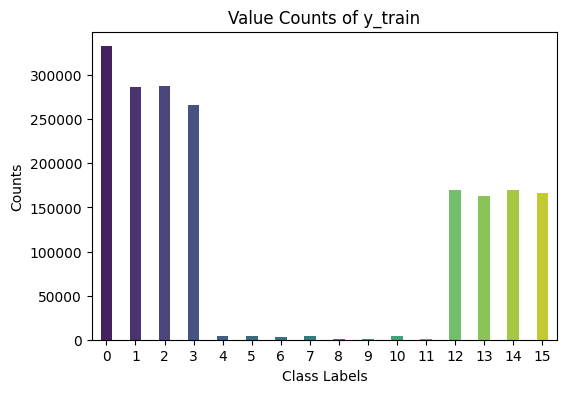

In [49]:
print ("After Under sampling:")
counts = pd.Series (Y_train). value_counts()
# Print the counts
print ("Counts of each class:")
print (counts)
# Plot the value counts
plt.figure(figsize=(6,4))
sns.barplot(x=counts. index, y=counts.values, palette="viridis", width = 0.4)
plt.xlabel ('Class Labels')
plt. ylabel ('Counts')
plt. title( 'Value Counts of y_train')
plt. show( )

In [53]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Assuming you already have your features and labels defined as X_train and Y_train
# Example class distribution
class_distribution = Y_train.value_counts()

# Define your desired sampling strategy based on your class distribution
# For example, you may want to keep the same number of samples as the minority class
# or you can define how many samples you want for each class
desired_samples = {label: count for label, count in class_distribution.items()}
# This could also be customized based on your specific requirements
# Example: desired_samples = {0: 200, 1: 200, 2: 200} for a 3-class problem

# Print the desired sampling strategy
print("Desired sampling strategy:", desired_samples)

# Initialize SMOTE with the defined strategy
smote = SMOTE(sampling_strategy=desired_samples)

# Perform the resampling
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, Y_train)

# Check the new class distribution
new_class_distribution = pd.Series(y_train_balanced).value_counts()
print("New class distribution after SMOTE:\n", new_class_distribution)


Desired sampling strategy: {0: 332674, 2: 288263, 1: 286911, 3: 266082, 14: 169472, 12: 169259, 15: 166283, 13: 163369, 10: 3823, 5: 3733, 4: 3724, 7: 3716, 6: 3027, 9: 1004, 11: 1003, 8: 993}
New class distribution after SMOTE:
 Label
0     332674
2     288263
1     286911
3     266082
14    169472
12    169259
15    166283
13    163369
10      3823
5       3733
4       3724
7       3716
6       3027
9       1004
11      1003
8        993
Name: count, dtype: int64


After Under sampling:
Counts of each class:
Label
0     332674
2     288263
1     286911
3     266082
14    169472
12    169259
15    166283
13    163369
10      3823
5       3733
4       3724
7       3716
6       3027
9       1004
11      1003
8        993
Name: count, dtype: int64


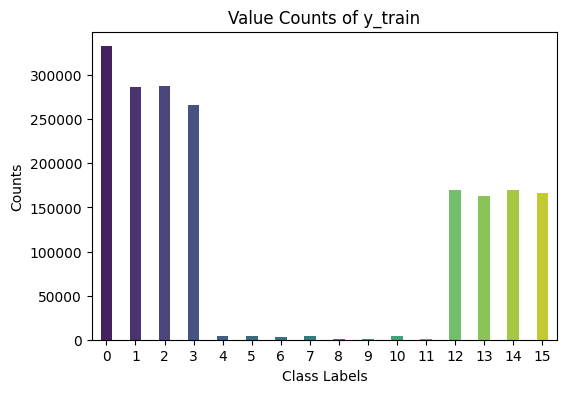

In [54]:
print("After Under sampling:")
counts = pd. Series (y_train_balanced).value_counts()
# Print the counts
print ("Counts of each class:")
print (counts)
# Plot the value counts
plt. figure(figsize=(6,4) )
sns.barplot(x=counts.index, y=counts.values, palette="viridis", width =0.4)
plt.xlabel('Class Labels')
plt.ylabel( 'Counts' )
plt.title( 'Value Counts of y_train')
plt.show( )

In [ ]:
dimensionality reduction

In [66]:
# Instantiate StandardScalfr
scaler = StandardScaler()
# Instantiate PCA
pca = PCA(n_components=0.95) # Adjust the number of components as needed
# Pipeline that first scales the data then reduces dimension with PCA
pipeline = make_pipeline(scaler, pca)
# Fit andtransform the data
X_train_pca = pipeline. fit_transform(X_train_balanced)

In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate_predictions(predictions, model):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, predictions)
    weighted_precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
    weighted_recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)
    class_report = classification_report(y_test, predictions, zero_division=0)

    # Print metrics
    print(f'Evaluation Metrics for {model}:')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {weighted_precision:.4f}")
    print(f"Weighted Recall: {weighted_recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n")
    print(class_report)


In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
rf = RandomForestClassifier(n_estimators=5, max_depth=10,random_state=42)
rf.fit(X_train_pca, y_train_balanced)
# Evaluate models
y_pred_rf = rf.predict(pipeline.transform(X_test))
# Evaluate the Random Forest model
# Evaluating the model
evaluate_predictions (y_pred_rf, model = 'Random forest')

AttributeError: This 'Pipeline' has no attribute 'transform'

In [78]:
evaluate_predictions (y_pred_rf, model = 'Random forest')

TypeError: evaluate_predictions() missing 1 required positional argument: 'y_test'